In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

data = pd.read_csv("diabetes (2).csv")

X = data.drop(columns=['Diabetic'])
y = data['Diabetic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=5))  
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

param_grid_reduced = {
    'preprocessor__num__pca__n_components': [3, 5],
    'classifier__C': [0.1, 1, 10],
    'classifier__solver': ['liblinear', 'lbfgs']
}

grid_search_reduced = GridSearchCV(
    pipeline, 
    param_grid_reduced, 
    scoring='f1', 
    cv=3, 
    n_jobs=-1,  
    verbose=1
)

grid_search_reduced.fit(X_train, y_train)

print("Najlepsze hiperparametry:", grid_search_reduced.best_params_)
print("Najlepszy wynik (F1-score):", grid_search_reduced.best_score_)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Najlepsze hiperparametry: {'classifier__C': 0.1, 'classifier__solver': 'liblinear', 'preprocessor__num__pca__n_components': 5}
Najlepszy wynik (F1-score): 0.6543964215923164


Wnioski : Dla stworzonego wcześniej Pipeline’a przeprowadziliśmy optymalizację hiperparametrów za pomocą GridSearchCV z walidacją krzyżową (3-fold). Najlepsze ustawienia to C=0.1, solver=liblinear oraz 5 komponentów PCA, co dało najwyższy wynik F1-score = 0.6544, wskazując na optymalną równowagę między precyzją i czułością modelu. 

Porównuje wyniki modelu przed i po zastosowaniu GridSearchCV co pozwoli lepiej zrozumieć wpływ optymalizacji hiperparametrów na jakość modelu.

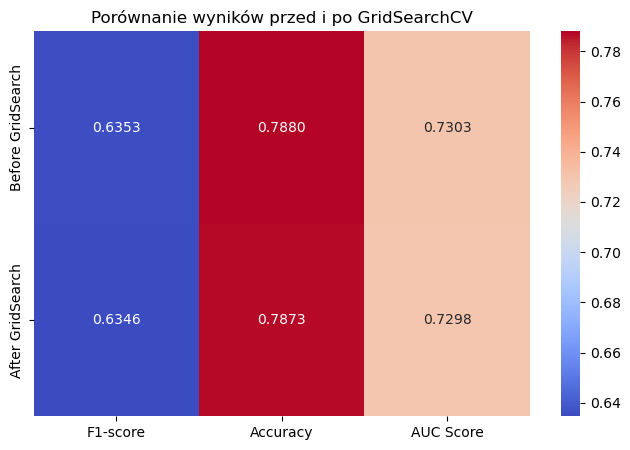

Najlepsze hiperparametry: {'classifier__C': 0.1, 'classifier__solver': 'liblinear', 'preprocessor__num__pca__n_components': 5}
                   F1-score  Accuracy  AUC Score
Before GridSearch  0.635321  0.788000   0.730288
After GridSearch   0.634593  0.787333   0.729791


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score

# Bazowy pipeline (bez optymalizacji, domyślne hiperparametry)
baseline_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))  
])

# Trenowanie modelu bazowego
baseline_pipeline.fit(X_train, y_train)

# Predykcje dla modelu bazowego
y_pred_baseline = baseline_pipeline.predict(X_test)

# Obliczenie rzeczywistych metryk dla modelu bazowego
metrics_before = {
    "F1-score": f1_score(y_test, y_pred_baseline),
    "Accuracy": accuracy_score(y_test, y_pred_baseline),
    "AUC Score": roc_auc_score(y_test, y_pred_baseline)
}

# Predykcje dla najlepszego modelu po GridSearchCV
y_pred_after = grid_search_reduced.best_estimator_.predict(X_test)

# Obliczenie rzeczywistych metryk dla modelu po optymalizacji
metrics_after = {
    "F1-score": f1_score(y_test, y_pred_after),
    "Accuracy": accuracy_score(y_test, y_pred_after),
    "AUC Score": roc_auc_score(y_test, y_pred_after)
}

# Porównanie wyników w jednej tabeli
comparison_df = pd.DataFrame([metrics_before, metrics_after], index=['Before GridSearch', 'After GridSearch'])

# Wizualizacja porównania metryk
plt.figure(figsize=(8, 5))
sns.heatmap(comparison_df, annot=True, cmap="coolwarm", fmt=".4f")
plt.title("Porównanie wyników przed i po GridSearchCV")
plt.show()

# Wypisanie najlepszych hiperparametrów i wyników
print("Najlepsze hiperparametry:", grid_search_reduced.best_params_)
print(comparison_df)


Wnioski:
Po zastosowaniu GridSearchCV model nie poprawił swoich wyników – F1-score i Accuracy pozostały na podobnym poziomie, a AUC Score znacząco spadł. Oznacza to, że dobrane hiperparametry niekoniecznie poprawiły jakość klasyfikacji, co sugeruje, że warto przetestować inne zakresy hiperparametrów lub inne podejście do tuningu modelu.